In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=7a7ec279fa8de9237fcadc36026069ccdee1176a575018d708b7989f687a595a
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [ ]:
!python -m medmnist available

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/
All available datasets:
	pathmnist
	chestmnist
	dermamnist
	octmnist
	pneumoniamnist
	retinamnist
	breastmnist
	bloodmnist
	tissuemnist
	organamnist
	organcmnist
	organsmnist
	organmnist3d
	nodulemnist3d
	adrenalmnist3d
	fracturemnist3d
	vesselmnist3d
	synapsemnist3d


In [ ]:
# !python -m medmnist download

In [ ]:
!wget https://zenodo.org/records/6496656/files/pneumoniamnist.npz

--2023-12-14 17:16:19--  https://zenodo.org/records/6496656/files/pneumoniamnist.npz
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.185.79.172, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4170669 (4.0M) [application/octet-stream]
Saving to: ‘pneumoniamnist.npz’

pneumoniamnist.npz  100%[===================>]   3.98M  2.91MB/s    in 1.4s    

2023-12-14 17:16:21 (2.91 MB/s) - ‘pneumoniamnist.npz’ saved [4170669/4170669]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from urllib.parse import urlsplit
import re
import cv2

from tabulate import tabulate
pd.set_option('display.max_columns', None)

from tqdm import tqdm
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from glob import glob
import seaborn as sns
from tabulate import tabulate
import random
import os
from tqdm import tqdm
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet, InceptionV3, VGG16, ResNet50
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import EarlyStopping

#importing metrics for model evaluation
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score,recall_score,f1_score,roc_auc_score,roc_curve
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')


import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the .npz file
data = np.load('pneumoniamnist.npz')

# get the data & labels
X_train = data['train_images']
X_val = data['val_images']
X_test = data['test_images']

y_train = data['train_labels'].flatten()
y_val = data['val_labels'].flatten()
y_test = data['test_labels'].flatten()

# Display shapes of the arrays
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4708, 28, 28)
X_val shape: (524, 28, 28)
X_test shape: (624, 28, 28)
y_train shape: (4708,)
y_val shape: (524,)
y_test shape: (624,)


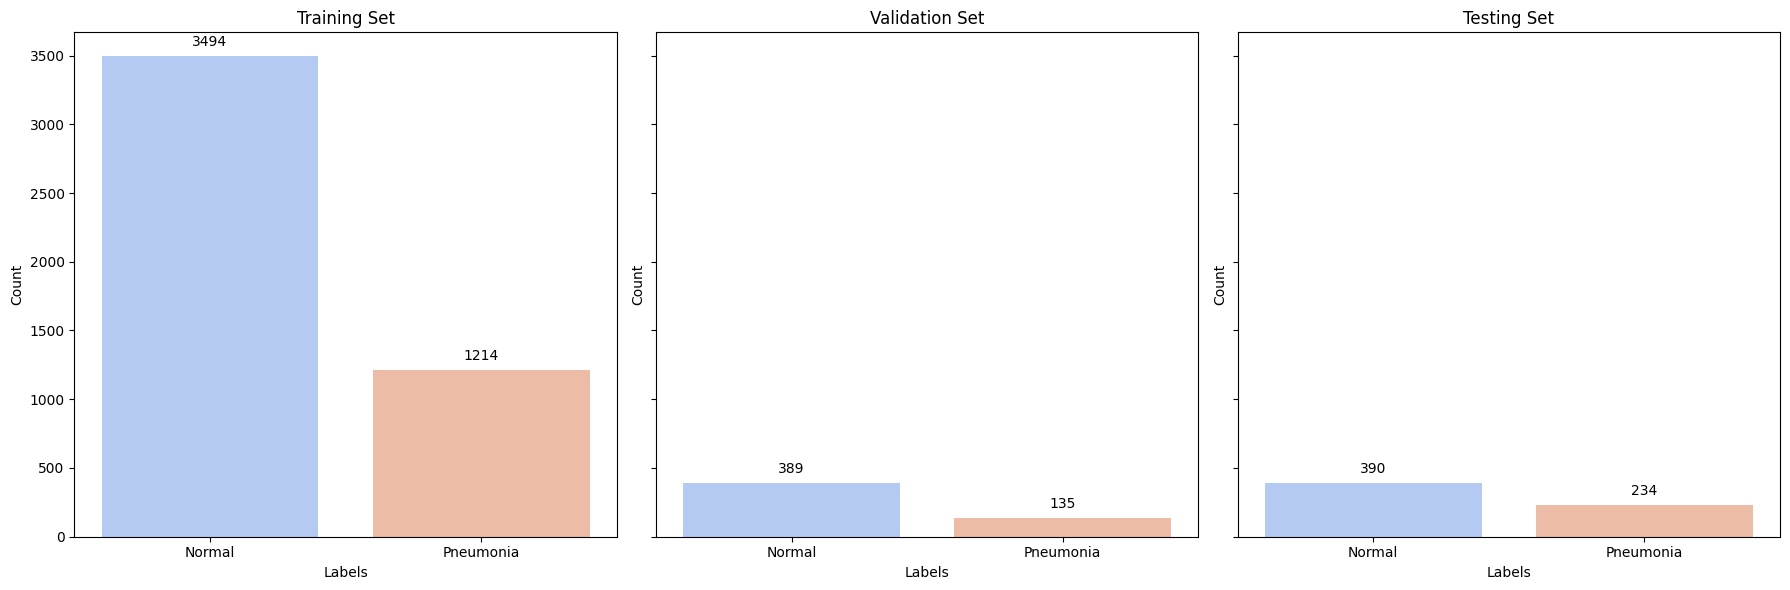

In [ ]:
# Map numeric labels to categories
label_mapping = {0: 'Pneumonia', 1: 'Normal'}
y_train_categories = np.vectorize(label_mapping.get)(y_train)
y_val_categories = np.vectorize(label_mapping.get)(y_val)
y_test_categories = np.vectorize(label_mapping.get)(y_test)

all_labels = np.concatenate((y_train_categories, y_val_categories, y_test_categories))

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot countplots for each dataset
for i, (data_set, title) in enumerate(zip([y_train_categories, y_val_categories, y_test_categories], ['Training Set', 'Validation Set', 'Testing Set'])):
    sns.countplot(x=data_set, palette='coolwarm', ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_xlabel('Labels')
    axes[i].set_ylabel('Count')

    for p in axes[i].patches:
        axes[i].annotate(format(p.get_height(), '.0f'),
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center',
                         va='center',
                         xytext=(0, 10),
                         textcoords='offset points',
                         fontsize=10,
                         color='black')

plt.tight_layout()
plt.show()

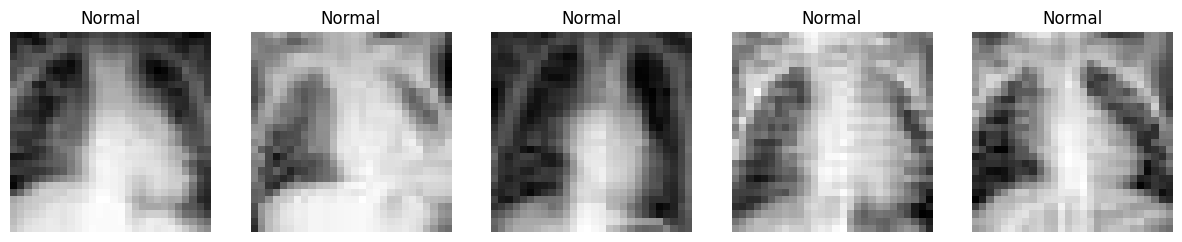

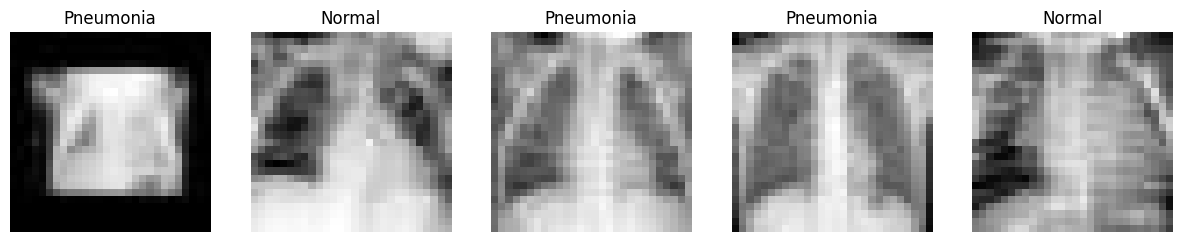

In [ ]:
# Function to plot random images with labels
def plot_random_images(images, labels, num_images=5):
    random_indices = np.random.choice(len(images), size=num_images, replace=False)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, idx in enumerate(random_indices):
        axes[i].imshow(images[idx], cmap='gray')
        axes[i].set_title(f"{labels[idx]}")
        axes[i].axis('off')
    plt.show()

# Plot random images with their labels from the training set
plot_random_images(X_train, y_train_categories)
plot_random_images(X_test, y_test_categories)

In [ ]:
height = 224
width = 224

In [ ]:
# Function to resize images and convert to grayscale or RGB
def resize_and_convert(images, new_shape=(224, 224)):
    resized_images = []
    for img in tqdm(images, desc='Processing'):
        if img.shape[-1] == 3:
          # Resize the image to the new shape
          resized = cv2.resize(img, new_shape)
          resized_images.append(resized)
        else:  # Image is grayscale or has a different number of channels
            # Resize the image to the new shape and add a third dimension for channels
            resized = cv2.resize(img, new_shape)
            resized = np.expand_dims(resized, axis=-1)
            resized_images.append(np.repeat(resized, 3, axis=-1))  # Convert to RGB
    return np.array(resized_images)

# Resize and convert images in X_train, X_test, X_val
X_train_resized = resize_and_convert(X_train, new_shape=(height, width))
X_test_resized = resize_and_convert(X_test, new_shape=(height, width))
X_val_resized = resize_and_convert(X_val, new_shape=(height, width))

Processing: 100%|██████████| 524/524 [00:00<00:00, 1498.30it/s]


In [ ]:
# Normalise all the images
def normalize_images(images):
  # convert into float32
  images = images.astype('float32')
  images /= 255.0
  return images

In [ ]:
X_train_resized = normalize_images(X_train_resized)
X_test_resized = normalize_images(X_test_resized)
X_val_resized = normalize_images(X_val_resized)
print("done.")

done.


In [ ]:
X_train_resized.shape

(4708, 224, 224, 3)

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)
# fitting
datagen.fit(X_train_resized)

In [ ]:
height, width, channel = (224,224,3)

Classes = ['Pneumonia', 'Normal']

In [ ]:
def LoadPretrainedModel(MODEL):
  # Load the pre-trained model
  pretrained_model = MODEL(weights='imagenet', include_top=False, input_shape=(height, width, channel))

  # Freeze the pre-trained layers to prevent their weights from being updated during training
  for layer in pretrained_model.layers:
      layer.trainable = False

  # Create a new model by adding your custom layers on top of the model
  model = tf.keras.Sequential([
      pretrained_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compile and summarize the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

## InceptionV3

In [ ]:
model_InceptionV3 = LoadPretrainedModel(InceptionV3)
print(model_InceptionV3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                        

In [ ]:
def TrainModel(model, X_train, y_train, X_test, y_test, epochs, batch_size, early_stopping, verbose):
  # Train the model with early stopping on train data and validate on test data
  history = model.fit(datagen.flow(X_train, y_train,
                                    batch_size=batch_size), epochs=epochs,verbose=verbose,validation_data=(X_test, y_test), callbacks=[early_stopping],
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    workers=4)
  return history

In [ ]:
EPOCHS = 20
BATCH_SIZE = 64

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = TrainModel(model_InceptionV3, X_train_resized, y_train, X_val_resized, y_val, EPOCHS, BATCH_SIZE, early_stopping, verbose = 1)

Epoch 1/20
73/73 [==============================] - 32s 283ms/step - loss: 0.3010 - accuracy: 0.8706 - val_loss: 0.2392 - val_accuracy: 0.9027
Epoch 2/20
73/73 [==============================] - 17s 232ms/step - loss: 0.2264 - accuracy: 0.9098 - val_loss: 0.1851 - val_accuracy: 0.9237
Epoch 3/20
73/73 [==============================] - 18s 234ms/step - loss: 0.1902 - accuracy: 0.9246 - val_loss: 0.1617 - val_accuracy: 0.9332
Epoch 4/20
73/73 [==============================] - 18s 232ms/step - loss: 0.1817 - accuracy: 0.9285 - val_loss: 0.1671 - val_accuracy: 0.9294
Epoch 5/20
73/73 [==============================] - 17s 225ms/step - loss: 0.1694 - accuracy: 0.9320 - val_loss: 0.1555 - val_accuracy: 0.9332
Epoch 6/20
73/73 [==============================] - 17s 225ms/step - loss: 0.1722 - accuracy: 0.9320 - val_loss: 0.1586 - val_accuracy: 0.9313
Epoch 7/20
73/73 [==============================] - 16s 210ms/step - loss: 0.1691 - accuracy: 0.9315 - val_loss: 0.1843 - val_accuracy: 0.9351

In [ ]:
def plotGraphs(history):
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs_range=range(len(history.history['loss']))

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

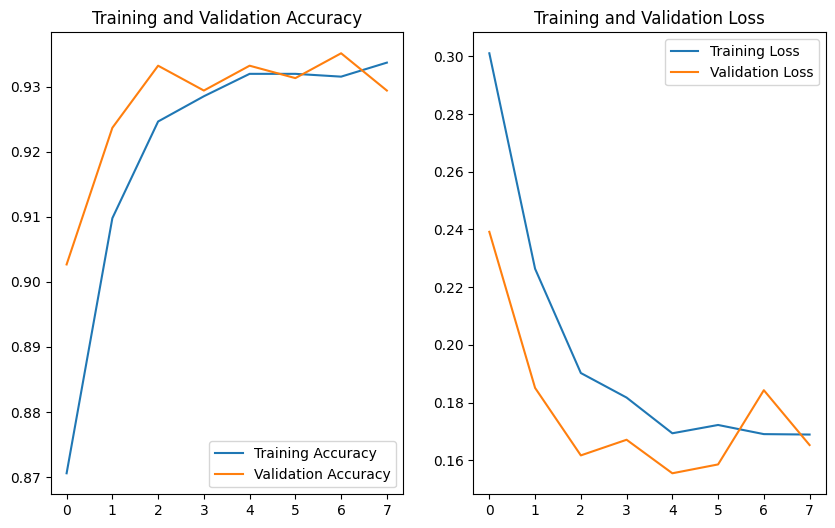

In [ ]:
plotGraphs(history)

In [ ]:
def predict_deep_learning_model(model, X_test, y_test, model_name):

  '''
  Pass the model and predict value.
  Function will calculate all the eveluation metrics and appending those metrics score on model_result table.
  Plotting confusion_matrix and roc_curve for test data.
  '''

  # predicting value and probability
  # prediction on testing data
  y_test_pred = model.predict(X_test, verbose=0)
  y_test_pred = np.where(y_test_pred>0.5, 1, 0).reshape(1,-1)[0]

  y_test_prob = model.predict(X_test)


  ''' Performance Metrics '''
  # accuracy score  ---->  TP+TN/TP+FP+TN+FN
  test_accuracy = accuracy_score(y_test, y_test_pred)
  print(f'Accuracy : {round(test_accuracy,3)}')

  # precision score  ---->  TP/TP+FP
  test_precision = precision_score(y_test, y_test_pred)
  print(f'Precision : {round(test_precision,3)}')

  # recall score  ---->  TP/TP+FN
  test_recall = recall_score(y_test, y_test_pred)
  print(f'Recall : {round(test_recall,3)}')

  # f1 score  ---->  Harmonic Mean of Precision and Recall
  test_f1 = f1_score(y_test, y_test_pred)
  print(f'F1-Score : {round(test_f1,3)}')

  # roc_auc score  ---->  It tells how much the model is capable of distinguishing between classes.
  test_roc_auc = roc_auc_score(y_test, y_test_prob)
  print(f'Roc_Auc : {round(test_roc_auc,3)}')
  print('-'*80)


  # classificatio report
  print(f'classification report for test data \n{classification_report(y_test, y_test_pred, target_names=Classes)}')
  print('-'*80)


  ''' plotting Confusion Matrix '''
  fig, ax = plt.subplots(figsize=(7,5))
  ConfusionMatrixDisplay.from_predictions(y_test_pred, y_test,
                                            ax=ax,
                                            display_labels=Classes,
                                            xticks_rotation='vertical')
  plt.title(f'confusion matrix on Test data ({model_name})', weight='bold')
  plt.show()
  print('-'*80)


  ''' plotting ROC curve '''
  fpr, tpr, threshold = roc_curve(y_test, y_test_prob)
  plt.plot(fpr,tpr, label=f'ROC - {model_name}')
  plt.plot([0,1], [0,1], '--')
  plt.title('ROC curve on Test data', weight='bold')
  plt.xlabel('False Positive Rate----->')
  plt.ylabel('True Positive Rate----->')
  plt.legend(loc=4)


  # appneding performance metrics score to make final model_result.
  return pd.DataFrame([{'model':model_name,
                       'Accuracy':test_accuracy,
                       'Precision':test_precision,
                       'Recall':test_recall,
                       'F1-Score':test_f1,
                       'ROC-AUC':test_roc_auc}])

## MobileNet

17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/20
73/73 [==============================] - 21s 234ms/step - loss: 0.2420 - accuracy: 0.8964 - val_loss: 0.1758 - val_accuracy: 0.9313
Epoch 2/20
73/73 [==============================] - 17s 225ms/step - loss: 0.1843 - accuracy: 0.9248 - val_loss: 0.1915 - val_accuracy: 0.9256
Epoch 3/20
73/73 [==============================] - 16s 214ms/step - loss: 0.1618 - accuracy: 0.9348 - val_loss: 0.1509 - val_accuracy: 0.9447
Epoch 4/20
73/73 [==============================] - 16s 211ms/step - loss: 0.1397 - accuracy: 0.9457 - val_loss: 0.1442 - val_accuracy: 0.9542
Epoch 5/20
73/73 [==============================] - 15s 202ms/step - loss: 0.1369 - accuracy: 0.9475 - val_loss: 0.1484 - val_accuracy: 0.9427
Epoch 6/20
73/73 [==============================] - 16s 206ms/step - loss: 0.1382 - accuracy: 0.9477 - val_loss: 0.1567 - val_accuracy: 0.9332
Epoch 7/20
73/73 [==============================] - 16s 210ms/step - loss: 0.

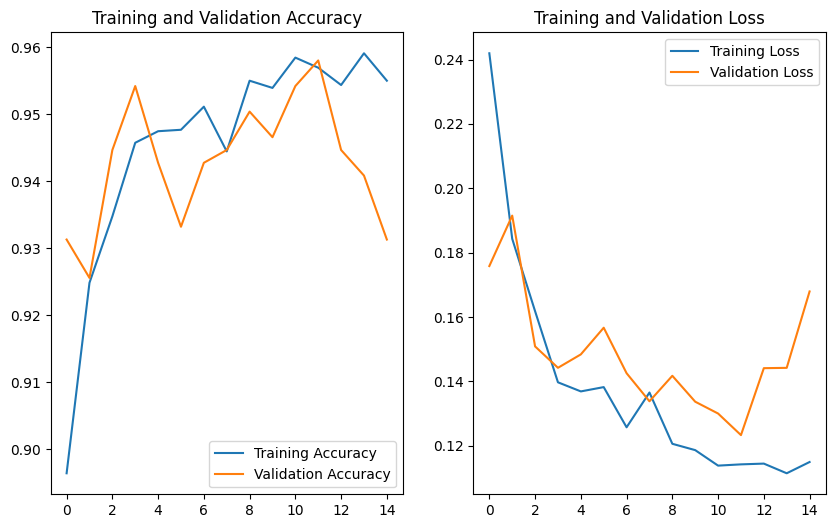

In [ ]:
model_MobileNet = LoadPretrainedModel(MobileNet)
history1 = TrainModel(model_MobileNet, X_train_resized, y_train, X_val_resized, y_val, EPOCHS, BATCH_SIZE, early_stopping, verbose = 1)
plotGraphs(history1)

## VGG16 Model

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
73/73 [==============================] - 37s 403ms/step - loss: 0.4425 - accuracy: 0.7922 - val_loss: 0.2981 - val_accuracy: 0.8626
Epoch 2/20
73/73 [==============================] - 20s 269ms/step - loss: 0.3017 - accuracy: 0.8654 - val_loss: 0.2716 - val_accuracy: 0.8702
Epoch 3/20
73/73 [==============================] - 20s 265ms/step - loss: 0.2888 - accuracy: 0.8745 - val_loss: 0.2820 - val_accuracy: 0.8721
Epoch 4/20
73/73 [==============================] - 20s 269ms/step - loss: 0.2763 - accuracy: 0.8816 - val_loss: 0.2503 - val_accuracy: 0.8912
Epoch 5/20
73/73 [==============================] - 20s 270ms/step - loss: 0.2632 - accuracy: 0.8822 - val_loss: 0.2327 - val_accuracy: 0.8989
Epoch 6/20
73/73 [==============================] - 21s 270ms/step - loss: 0.2568 - accuracy: 0.8913 - val_loss: 0.2145 - val_accuracy: 0.9027
Epoch 7/20
73/73 [==============================] - 20s 269ms/step - loss: 0.

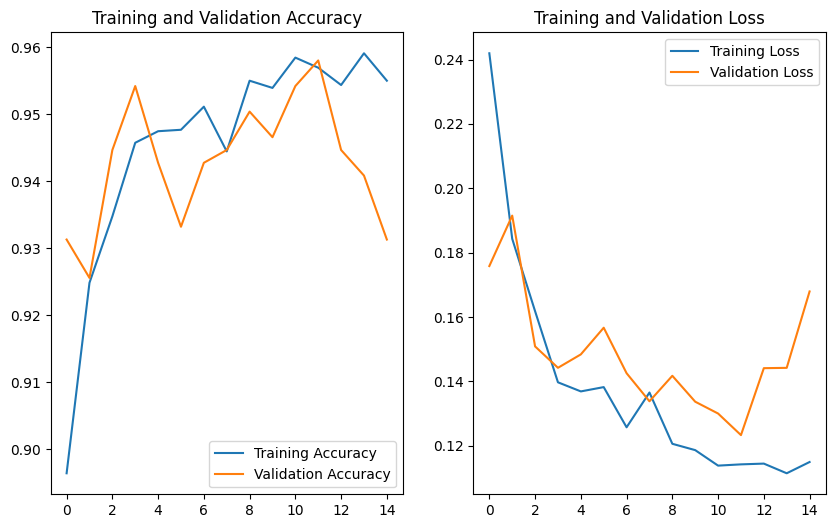

In [ ]:
model_VGG16 = LoadPretrainedModel(VGG16)
history2 = TrainModel(model_VGG16, X_train_resized, y_train, X_val_resized, y_val, EPOCHS, BATCH_SIZE, early_stopping, verbose = 1)
plotGraphs(history1)

In [ ]:
def save_model(model, filename):
    model.save(filename)

In [ ]:
# Save the trained model
save_model(model_MobileNet, '/content/drive/MyDrive/MNIST_RES/mobilenet_trained_model.h5')

## Models Evaluation

In [ ]:
models_pd = pd.concat([InceptionV3_res, MobileNet_res, VGG16_res]).reset_index(drop=True).round(3)
print(models_pd)

,model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,InceptionV3,0.849,0.816,0.979,0.890,0.956
1,MobileNet,0.859,0.820,0.992,0.898,0.958
2,VGG16,0.796,0.761,0.982,0.858,0.927


MobileNet demonstrates the highest overall performance among the models, showcasing strong accuracy, precision, recall, and F1-score. Its accuracy of 85.9% combined with high precision (82%) and recall (99.2%) indicates a well-balanced performance, making it the top-performing model.

InceptionV3 also exhibits commendable performance with slightly lower accuracy than MobileNet but maintaining a well-rounded precision, recall, and F1-score, showcasing an accuracy of 84.9% and a balanced F1-score of 0.89.

## Train Machine Learning Models

In [ ]:
from keras.models import load_model

# Load the saved model
loaded_best_model = load_model('/content/drive/MyDrive/MNIST_RES/mobilenet_trained_model.h5')

In [ ]:
def features_extraction_cnn(best_model):
  # Freeze the pre-trained layers to prevent their weights from being updated during training
  for layer in best_model.layers:
      layer.trainable = False

  feature_extractor_train = best_model.predict(X_train_resized, verbose=0)
  feature_extractor_test = best_model.predict(X_test_resized, verbose=0)

  features_train = feature_extractor_train.reshape(feature_extractor_train.shape[0], -1)
  features_test = feature_extractor_test.reshape(feature_extractor_test.shape[0], -1)

  # Create a DataFrame from the reshaped features
  df_train = pd.DataFrame(data=features_train, columns=[f'feature_{i+1}' for i in range(features_train.shape[1])])
  df_test = pd.DataFrame(data=features_test, columns=[f'feature_{i+1}' for i in range(features_test.shape[1])])

  return df_train, df_test

In [ ]:
loaded_best_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
train_df, test_df = features_extraction_cnn(loaded_best_model)

In [ ]:
train_df['Output'] = y_train
train_df['data'] = 'training'

test_df['Output'] = y_test
test_df['data'] = 'test'

In [ ]:
final_dataset = pd.concat([train_df, test_df])
final_dataset.shape

(5332, 50178)

In [ ]:
XX = final_dataset.drop(['Output', 'data'], axis = 1)
yy = final_dataset[['Output', 'data']]

In [ ]:
from sklearn.decomposition import PCA


# Create a PCA instance with the desired explained variance ratio
desired_variance_ratio = 0.95
pca = PCA(n_components=desired_variance_ratio)

# Fit PCA on the features
pca.fit(XX)

# Transform the features using PCA
reduced_features = pca.transform(XX)

# Create a DataFrame from the reduced features
reduced_features_df = pd.DataFrame(data=reduced_features, columns=[f'PC{i+1}' for i in range(reduced_features.shape[1])])

# Print the number of retained features
num_retained_features = reduced_features.shape[1]
print(f"Number of retained features after reduction: {num_retained_features}")

Number of retained features after reduction: 2617


In [ ]:
df_pca = pd.DataFrame(reduced_features, columns=[f'pca_{i+1}' for i in range(num_retained_features)])
df_pca.head()

pca_1      pca_2      pca_3      pca_4      pca_5      pca_6  \
0  24.191628 -37.934864 -11.333735  -7.549445  -9.990462 -25.040380   
1  14.188992  57.697319 -46.767086   5.691301   8.322953  12.268397   
2   6.400974  23.377552 -17.782997 -18.702971  -2.512314  20.107483   
3 -67.571205  -1.111102  22.060261  25.208971  22.801336  -4.181547   
4 -45.251640  21.234192 -17.222591  26.452963  -6.118986   7.414910   

       pca_7      pca_8      pca_9    pca_10     pca_11    pca_12    pca_13  \
0   5.025340 -12.589220  12.544847  5.386530   5.677350  2.990379  3.916814   
1   4.689342   4.301306  30.870312  8.917104 -17.319933  1.125180  2.705617   
2 -26.155716 -16.162823  16.314348  3.640452 -13.301641  8.941950 -7.395195   
3  -0.232571   0.175559  -6.695295  5.856732  14.453611 -4.573040  2.375635   
4   3.977039  -3.831304   5.421985  4.704823  10.952189  2.068959 -4.381846   

      pca_14     pca_15     pca_16     pca_17     pca_18     pca_19  \
0  -9.881819  -1.841043 -12.367059 -19.370464 -25.830212  -7.911957   
1  10.379980   9.036036  -7.835684   4.403715   8.385637  -0.929319   
2 -19.768766  -0.616640 -15.896974  14.039233   5.376979   0.388141   
3   2.260616 -11.016686   3.472732   4.025296   6.006136   4.017159   
4  -0.497024  -9.492738  11.932906   1.135178  -7.374291 -11.753738   

      pca_20     pca_21     pca_22    pca_23     pca_24    pca_25     pca_26  \
0 -13.083115  13.042905  -6.424123 -1.209643   3.352105 -6.696675  -8.884627   
1   4.141116   1.724917 -10.810497  5.984891  21.500259  4.519377   2.750772   
2  -3.364875  -9.320087  -9.382182 -4.504333 -12.734636  1.577417  11.984361   
3  -1.877625  -2.677866   6.302079  7.402651  -6.686645 -2.605502   7.839899   
4  16.262415  12.177870   7.152130  8.813696   3.684408 -5.590630  12.050247   

      pca_27     pca_28     pca_29     pca_30    pca_31     pca_32     pca_33  \
0  -9.313796 -11.447611  -3.529397  -6.449117  4.368683  11.327168   7.600100   
1 -24.307098   1.547178   7.098889  -1.033407  1.787413 -14.015206  12.054954   
2   0.844548   1.693727 -14.563452  14.693963  3.509480   5.992286   9.516738   
3 -11.950989  -2.803293  -8.428685  -5.245574  0.692876  -7.885915  18.154472   
4   2.809987  -9.420276  20.449024  -2.974887  2.081596  -5.800304   4.686677   

      pca_34    pca_35     pca_36     pca_37     pca_38    pca_39    pca_40  \
0 -19.836414 -2.269975 -12.312723   0.834532  10.872639  2.387954 -8.195405   
1  10.698176 -2.705389  -4.491157   3.674338 -23.786430  9.281429  2.783695   
2   6.115749  1.119381  -1.791157  -4.378415   4.925062 -5.945793 -7.790776   
3  -0.460106 -9.129677   7.358116   4.129155   6.987122  5.965234 -3.534909   
4  -3.943260  3.227704  -9.644998  17.720806   2.489007  8.587908  8.714172   

     pca_41     pca_42    pca_43    pca_44     pca_45    pca_46     pca_47  \
0  8.556109  -1.582152  6.502882 -4.194343 -10.542281  2.170646   7.803955   
1  0.847610  10.694639  4.646452 -1.895604  -3.983449 -1.113530  10.346127   
2 -3.117367  -5.892251  0.580119 -5.301591  -2.295998 -0.345753   6.876796   
3  0.747447  -2.889271  2.652903  0.052641  -5.636074 -8.216422   3.035034   
4 -2.282950   8.342265  0.805524  5.406326  -6.071176  6.136151  -6.634447   

      pca_48    pca_49     pca_50     pca_51     pca_52    pca_53    pca_54  \
0  13.908574  3.074706 -12.412302 -10.744863  -9.084473  0.098422  6.653169   
1  -0.477940  3.225910   5.657533   8.271667 -11.868845  2.211627 -0.068380   
2  -6.247406  0.641554  -7.859824  -1.236226  -3.681989 -2.304585  3.774817   
3  -3.829250 -5.525099  -0.823484   2.741652  -5.842781  5.695672  2.200627   
4  -3.854651  5.285496  -0.130343  -1.221826   8.644710 -3.863065  3.831334   

      pca_55    pca_56    pca_57     pca_58    pca_59    pca_60    pca_61  \
0  10.339935 -1.987748 -8.232947 -11.544011  2.967829  0.577643 -1.336970   
1   1.645746 -4.844334 -0.695359   1.331988 -6.098238  1.254063  4.573565   
2   0.168211  4.905865 -3.429820   1.911924  1.425157  0.755

In [ ]:
df_pca[['Output', 'data']] = final_dataset[['Output', 'data']].values

In [ ]:
df_pca.to_csv("/content/drive/MyDrive/MNIST_RES/pca_features.csv", index=False)

In [ ]:
df_train = df_pca[df_pca['data']=='training']
df_test = df_pca[df_pca['data']=='test']

XX_train, yy_train = df_train.drop(['Output', 'data'], axis = 1), df_train['Output']
XX_val, yy_val= df_test.drop(['Output', 'data'], axis = 1), df_test['Output']
XX_train.shape, XX_val.shape

((4708, 2617), (624, 2617))

In [ ]:
yy_train = yy_train.astype(int)
yy_val = yy_val.astype(int)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
def predict_ml_model(ml_model,X_train, y_train, X_test, y_test, model_name):

  '''
  Pass the model and predict value.
  Function will calculate all the eveluation metrics and appending those metrics score on model_result table.
  Plotting confusion_matrix and roc_curve for test data.
  '''

  # model fitting
  model = ml_model.fit(X_train, y_train)

  # predicting value and probability
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  y_train_prob = model.predict_proba(X_train)[:,1]
  y_test_prob = model.predict_proba(X_test)[:,1]


  ''' Performance Metrics '''
  # accuracy score  ---->  TP+TN/TP+FP+TN+FN
  train_accuracy = accuracy_score(y_train, y_train_pred)
  test_accuracy = accuracy_score(y_test, y_test_pred)
  print(f'train accuracy : {round(train_accuracy,3)}')
  print(f'test accuracy : {round(test_accuracy,3)}')

  # precision score  ---->  TP/TP+FP
  test_precision = precision_score(y_test, y_test_pred)
  print(f'test precision : {round(test_precision,3)}')

  # recall score  ---->  TP/TP+FN
  test_recall = recall_score(y_test, y_test_pred)
  print(f'test recall : {round(test_recall,3)}')

  # f1 score  ---->  Harmonic Mean of Precision and Recall
  test_f1 = f1_score(y_test, y_test_pred)
  print(f'test f1 : {round(test_f1,3)}')

  # roc_auc score  ---->  It tells how much the model is capable of distinguishing between classes.
  test_roc_auc = roc_auc_score(y_test, y_test_prob)
  print(f'test roc_auc : {round(test_roc_auc,3)}')
  print('-'*80)

  # classificatio report
  print(f'classification report for test data \n{classification_report(y_test, y_test_pred)}')
  print('-'*80)


  ''' plotting Confusion Matrix '''
  ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
  plt.title('confusion matrix on Test data', weight='bold')
  plt.show()
  print('-'*80)


  ''' plotting ROC curve '''
  fpr, tpr, threshold = roc_curve(y_test, y_test_prob)
  plt.plot(fpr,tpr, label=f'ROC - {model_name}')
  plt.plot([0,1], [0,1], '--')
  plt.title('ROC curve on Test data', weight='bold')
  plt.xlabel('False Positive Rate----->')
  plt.ylabel('True Positive Rate----->')
  plt.legend(loc=4)


  # appneding performance metrics score to make final model_result.
  return pd.DataFrame([{'model':model_name,
                       'Training accuracy':train_accuracy,
                       'Testing Accuracy':test_accuracy,
                       'Precision':test_precision,
                       'Recall':test_recall,
                       'F1-Score':test_f1,
                       'ROC-AUC':test_roc_auc}])

In [ ]:
models_pd = pd.concat([lr_res, rf_res, lgb_res]).reset_index(drop=True)
models_pd

,model,Training accuracy,Testing Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,LogisticRegression,1.0,0.870192,0.830835,0.994872,0.905484,0.964004
1,RandomForestClassifier,1.0,0.770833,0.739806,0.976923,0.841989,0.914815
2,LGBMClassifier,1.0,0.841346,0.803758,0.987179,0.886076,0.959807


In [ ]:
def plot_performance_metrics_graph(models_pd):
  plt.figure(figsize=(13, 6))

  index = np.arange(len(models_pd['model']))
  bar_width = 0.2

  accuracy = plt.bar(index, models_pd['Testing Accuracy'], bar_width, label='Testing Accuracy', color='skyblue')
  precision = plt.bar(index + bar_width, models_pd['Precision'], bar_width, label='Precision', color='orange')
  recall = plt.bar(index + 2 * bar_width, models_pd['Recall'], bar_width, label='Recall', color='green')
  f1 = plt.bar(index + 3 * bar_width, models_pd['F1-Score'], bar_width, label='F1', color='red')

  # Add text labels to each bar
  def autolabel(rects):
      for rect in rects:
          height = rect.get_height()
          plt.text(rect.get_x() + rect.get_width() / 2., height, '{:.3f}%'.format(height),
                  ha='center', va='bottom', fontsize=8)

  # Customize the plot
  autolabel(accuracy)
  autolabel(precision)
  autolabel(recall)
  autolabel(f1)

  plt.xlabel('Model')
  plt.ylabel('Score')
  plt.title('Performance Metrics for Different Models')
  plt.xticks(index + 2 * bar_width, models_pd['model'], rotation=45)
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.tight_layout()
  plt.xticks(rotation=90)
  plt.savefig('overall.png')
  plt.show()

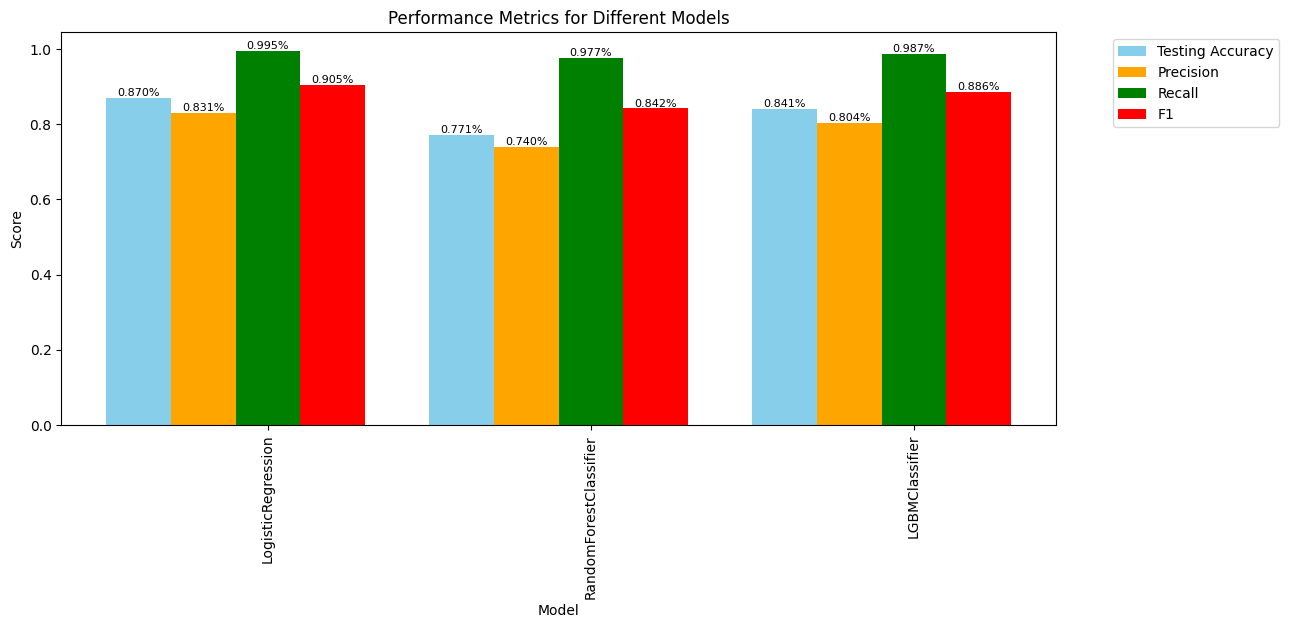

In [ ]:
plot_performance_metrics_graph(models_pd)